In [2]:
import glob
import os
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import yaml
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import stats

plt.style.use(["science", "nature"])
import pickle

plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['axes.labelsize'] = 6
plt.rcParams["xtick.top"] = False
plt.rcParams["ytick.right"] = False
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 5
plt.rcParams['hatch.linewidth'] = 0.5

%matplotlib widget

protocol_map = {
    "Visium": "10X Visium",
    "VisiumHD": "10X Visium HD",
    "Chromium": "10X Chromium",
    "Dropseq": "Drop-seq",
    "Stereoseq": "Stereo-seq",
    "Slideseq": "Slide-seq V2",
    "SpatialTranscriptomics": "ST",
    "Microwell": "Microwell-seq",
    "annotation": "Annotated PAS",
    "Annotation": "Annotated PAS",
}
type_map = {
    "Visium": "Spatial transcriptome",
    "VisiumHD": "Spatial transcriptome",
    "Chromium": "scRNA-seq",
    "Dropseq": "scRNA-seq",
    "Stereoseq": "Spatial transcriptome",
    "Slideseq": "Spatial transcriptome",
    "SpatialTranscriptomics": "Spatial transcriptome",
    "Microwell": "scRNA-seq",
}
order = ["10X Chromium", "Drop-seq", "Microwell-seq", "10X Visium","Stereo-seq", "Slide-seq V2", "ST"]
# order = ["10X Chromium", "Drop-seq", "Microwell-seq", "10X Visium", "10X Visium HD","Stereo-seq", "Slide-seq V2", "Spatial Transcriptomics"]

color = [
    "#386b98",
    "#269a51",
    "#edaa4d",
    "#d34123",
    "#7e648a",
    "#454545",
    "#929292",
]
palette=sns.color_palette(color, 7)
mm = 1/25.4

In [2]:
# peak cov
cov_path = "/root/apabenchmark/data/raw_bam_feature/pas_cov/pas_500_cov.csv"
cov_df = pd.read_csv(cov_path)
cov_df["protocol"] = cov_df["protocol"].map(protocol_map)

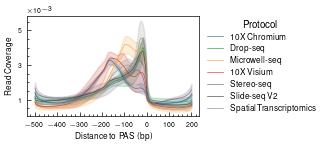

In [5]:
# cs type
cs_motif_unmatch_cat = "/root/apabenchmark/data/raw_bam_feature/cs_motif/motif_category_unmatch.csv"
cs_motif_unmatch_df = pd.read_csv(cs_motif_unmatch_cat).fillna("None")
cs_motif_unmatch_df = cs_motif_unmatch_df.groupby(["protocol", "category","type"])["count"].sum().reset_index()
cs_motif_unmatch_df["prop"] = cs_motif_unmatch_df.groupby(["protocol","type"])["count"].transform(lambda x: x / x.sum())
cs_motif_unmatch_df["protocol"] = cs_motif_unmatch_df["protocol"].map(protocol_map)
cs_motif_unmatch_df["protocol"] = pd.Categorical(cs_motif_unmatch_df["protocol"], categories=order+["Annotated PAS"])
cs_motif_unmatch_df = cs_motif_unmatch_df.sort_values("protocol")
# cs_motif_unmatch_df["protocol"] = cs_motif_unmatch_df["protocol"].map(protocol_map)

In [6]:
cs_motif_match_cat = "/root/apabenchmark/data/raw_bam_feature/cs_motif/motif_category_match.csv"
cs_motif_match_df = pd.read_csv(cs_motif_match_cat).fillna("None")
cs_motif_match_df = cs_motif_match_df.groupby(["protocol", "category","type"])["count"].sum().reset_index()
cs_motif_match_df["prop"] = cs_motif_match_df.groupby(["protocol","type"])["count"].transform(lambda x: x / x.sum())
cs_motif_match_df["protocol"] = cs_motif_match_df["protocol"].map(protocol_map)
cs_motif_match_df["protocol"] = pd.Categorical(cs_motif_match_df["protocol"], categories=order+["Annotated PAS"])
cs_motif_match_df = cs_motif_match_df.sort_values("protocol")
annotated_df = cs_motif_unmatch_df[cs_motif_unmatch_df["protocol"] == "Annotated PAS"].copy()
annotated_df["type"] = annotated_df["type"].str.replace("un","")
cs_motif_match_df = pd.concat([cs_motif_match_df, annotated_df])

In [7]:
cs_motif_df = pd.concat([cs_motif_unmatch_df, cs_motif_match_df])

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 2 with shape (2,).

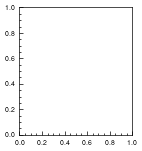

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

plt.close()
fig = plt.figure(figsize=(170*mm, 42*mm))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])

bar_width = 0.7
protocol_padding = 0.2
protocols = cs_motif_df['protocol'].unique()
types = ["match_utr", "match_nonutr", "unmatch_utr", "unmatch_nonutr"]
title = ["Matched 3'UTR CS", "Matched Non 3'UTR CS", "Unmatched 3'UTR CS", "Unmatched Non 3'UTR CS"]
motif_categorys = [
    "PAS Major + CFI/II",
    "PAS Major only",
    "PAS Other + CFI/II",
    "PAS Other only",
    "CFI/II only",
    "None"
]

for i, type_ in enumerate(types):
    ax = plt.subplot(gs[i])
    y = np.arange(len(protocols))
    left = np.zeros(len(protocols))
    for j, motif_category in enumerate(motif_categorys):
        data = cs_motif_df[(cs_motif_df["category"] == motif_category) & (cs_motif_df["type"] == type_)]["prop"].values
        if data.shape[0] == 0:
            continue
        ax.barh(y, data, bar_width, left=left, label=motif_category, color=palette[j], edgecolor='black')
        left += data

    ax.set_xlim([0, 1])
    
    ax.set_ylim([-0.5, len(protocols) - 0.5])
    ax.tick_params(which='both', left=False)
    ax.set_xlabel('Proportion')
    ax.set_ylabel('')
    ax.set_yticks(y)
    ax.set_yticklabels(protocols, fontsize=6)
    ax.set_title(title[i], fontsize=6)
    ax.set_ylim([y[0] - bar_width/2 - protocol_padding, y[-1] + bar_width])
    if i != 0:
        ax.tick_params(labelleft=False)
    ax.invert_yaxis()

motif_handles = [plt.Rectangle((0, 0), 1, 1, facecolor=color, edgecolor='black', linewidth=1) for color in palette]
motif_labels = motif_categorys
motif_legend = plt.legend(motif_handles, motif_labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6, )

fig.tight_layout()
fig.subplots_adjust(wspace=0.1, bottom=0.2)

plt.savefig("../../figures/fig2/cs_motif.pdf", dpi=300, bbox_inches="tight")

In [3]:
from tqdm import tqdm
# peak params
params_pickle_list = glob.glob("/root/apabenchmark/data/peak_params/*.pkl")
coverage_dict = {}
params_df = pd.DataFrame()
for i, pickle_file in tqdm(enumerate(params_pickle_list)):
    with open(pickle_file, "rb",) as f:
        coverage, dist_df = pickle.load(f)
    protocol = pickle_file.split("/")[5].split("_")[0]
    coverage_dict[pickle_file] = coverage
    dist_df["protocol"] = protocol_map[protocol]
    dist_df["sample"] = "_".join(pickle_file.split("/")[-1].split("_")[0:4])
    params_df = pd.concat([params_df, dist_df])

28it [00:07,  3.72it/s]


In [7]:
raw_data_feature_df = raw_data_feature_df[raw_data_feature_df["protocol"] != "10X Visium HD"]
raw_data_feature_df["protocol"] = pd.Categorical(raw_data_feature_df["protocol"], categories=order)
raw_data_feature_df = raw_data_feature_df.sort_values("protocol")

In [14]:
with open("/root/apabenchmark/data/archive_pickle/raw_data_feature_df.pkl", "wb") as f:
    pickle.dump(raw_data_feature_df, f)

In [8]:
mm = 1/25.4
width = 170
height = 220

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# from matplotlib.patches import Ellipse
# import numpy as np
# from scipy.stats import chi2

# # 绘制散点图
# fig, ax = plt.subplots(figsize=(88*mm,42*mm))

# sns.scatterplot(
#     data=raw_data_feature_df,
#     x="apex_position_var",
#     y="kurtosis_var",
#     hue="protocol",
#     style="protocol",
#     hue_order=order,
#     palette=palette,
#     ax=ax
# )
# # ax.set_yticks([2, 4, 6])


# # 为每个组添加同色椭圆
# for protocol in raw_data_feature_df["protocol"].unique():
#     data = raw_data_feature_df[raw_data_feature_df["protocol"] == protocol]
#     x = data["apex_position_var"]
#     y = data["kurtosis_var"]
    
#     # 计算椭圆参数
#     cov = np.cov(x, y)
#     mean = np.mean([x, y], axis=1)
    
#     # 计算椭圆的半径（置信区间为95%）
#     eigenvalues, eigenvectors = np.linalg.eig(cov)
#     chi = chi2.ppf(0.95, 2)
#     radius_x = np.sqrt(eigenvalues[0] * chi)
#     radius_y = np.sqrt(eigenvalues[1] * chi)
    
#     # 计算椭圆的旋转角度
#     angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
#     ellipse = Ellipse(mean,
#                       width=2 * radius_x,
#                       height=2 * radius_y,
#                       angle=angle,
#                       facecolor='none',
#                       edgecolor=ax.get_legend().legendHandles[order.index(protocol)].get_color())
    
#     # 添加椭圆到图上
#     ax.add_patch(ellipse)
# ax.set_ylabel("Kurtosis variance")
# ax.set_xlabel("Apex position variance")
# ax.tick_params(which="both", top=False, right=False,)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)

# plt.subplots_adjust(right=0.6)
# plt.savefig("../../figures/fig2/apex_position_var_kurtosis_var.pdf", bbox_inches='tight')
# plt.show()


/tmp/ipykernel_638537/236860212.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
/tmp/ipykernel_638537/236860212.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)


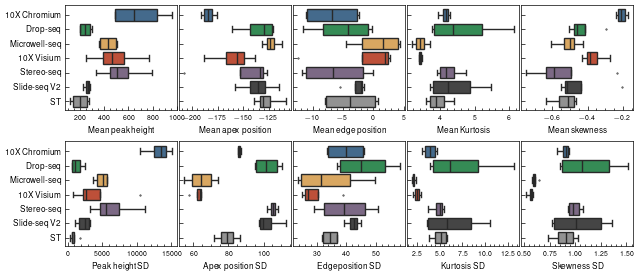

In [11]:
for feature in feature_list:
    raw_data_feature_df[f"{feature}_zscore"] = (raw_data_feature_df[feature] - raw_data_feature_df[feature].mean() ) / raw_data_feature_df[feature].std()

In [12]:
raw_data_feature_df["peak_variance"] = raw_data_feature_df[[
    # "peak_height_std_zscore",
    "apex_position_std_zscore",
    "edge_position_std_zscore",
    "kurtosis_std_zscore",
    "skewness_std_zscore",
]].mean(axis=1)

/tmp/ipykernel_638537/2636073458.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)


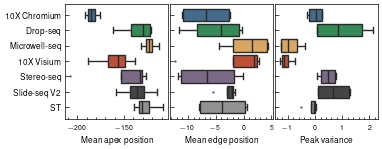

In [13]:
plt.close()
fig, axs = plt.subplots(
    1, 3, figsize=(100*mm,40*mm),sharey=True
)

feature_list = [
    "apex_position_mean",
    "edge_position_mean",
    "peak_variance",
    ]
feature_label_map = {
    "peak_height_mean": "Mean peak height",
    "apex_position_mean": "Mean apex position",
    "edge_position_std": "Edge position SD",
    "kurtosis_mean": "Mean Kurtosis",
    "apex_position_std": "Apex position SD",
    "edge_position_mean": "Mean edge position",
    "kurtosis_std": "Kurtosis SD",
    "peak_height_std": "Peak height SD",
    "skewness_mean": "Mean skewness",
    "skewness_std": "Skewness SD",
    "peak_variance": "Peak variance",
    "peak_consistency": "Peak consistency",
}

for i, feature in enumerate(feature_list):
    ax = axs[i]
    sns.boxplot(
        data=raw_data_feature_df,
        y="protocol",
        x=feature,
        order=order,
        palette=palette,
        hue="protocol",
        legend=False,
        ax=ax,
        fliersize=0.5,
    )
    ax.set_xlabel(feature_label_map[feature],fontsize=6)
    ax.tick_params(which="both", top=False, right=False)
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.tick_params(which="minor", left=False)
    if i == 0 :
        ax.set_yticklabels(ax.get_yticklabels(), fontsize=6)
        ax.set_ylabel("")
    ax.set_ylim([ax.get_ylim()[0]+0.3, ax.get_ylim()[1]-0.2])
plt.tight_layout()
plt.subplots_adjust(wspace=0.02, bottom=0.2)
plt.savefig("../../figures/fig2/fig2c.pdf", bbox_inches='tight',dpi=300)

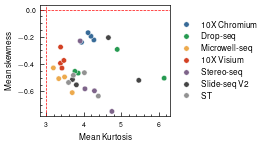

In [15]:
plt.close()
fig, ax = plt.subplots(
    1, 1, figsize=(70*mm,40*mm),sharey=True
)
sns.scatterplot(
    data=raw_data_feature_df,
    x="kurtosis_mean",
    y="skewness_mean",
    hue="protocol",
    hue_order=order,
    palette=palette,
    s=15,
    ax=ax
)
ax.set_xlabel(feature_label_map["kurtosis_mean"],fontsize=6)
ax.set_ylabel(feature_label_map["skewness_mean"],fontsize=6)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6)
ax.axvline(3, color="red", linestyle="--")
ax.axhline(0, color="red", linestyle="--")
ax.set_yticks([-0.6, -0.4, -0.2, 0])
plt.tight_layout()
plt.savefig("../../figures/fig2/fig2d.pdf", bbox_inches='tight',dpi=300)

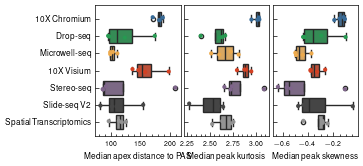

No such comm: 3b6e534f293640ecbfc231ff80a65229


In [38]:
plt.close()
fig, (ax0, ax1, ax2) = plt.subplots(
    1, 3, figsize=(95*mm,45*mm)
)

sns.boxplot(
    data=raw_data_feature_df,
    y="protocol",
    x="apex_position_median",
    hue="protocol",
    hue_order=order,
    ax=ax0,
    palette=palette,
)
# 添加散点图
sns.stripplot(
    data=raw_data_feature_df,
    y="protocol",
    x="apex_position_median",
    hue="protocol",
    hue_order=order,
    dodge=False,
    size=3,
    ax=ax0,
    palette=palette,
)

ax0.set_xlabel("Median apex distance to PAS")
ax0.yaxis.set_tick_params(labelsize=6)

sns.boxplot(
    data=raw_data_feature_df,
    y="protocol",
    x="kurtosis_median",
    hue="protocol",
    hue_order=order,
    ax=ax1,
    palette=palette
)
# 添加散点图
sns.stripplot(
    data=raw_data_feature_df,
    y="protocol",
    x="kurtosis_median",
    hue="protocol",
    hue_order=order,
    dodge=False,
    size=3,
    ax=ax1,
    palette=palette
)
ax1.set_yticklabels([])
ax1.set_xlabel("Median peak kurtosis")

sns.boxplot(
    data=raw_data_feature_df,
    y="protocol",
    x="skewness_median",
    hue="protocol",
    hue_order=order,
    ax=ax2,
    palette=palette,
)
# 添加散点图
sns.stripplot(
    data=raw_data_feature_df,
    y="protocol",
    x="skewness_median",
    hue="protocol",
    hue_order=order,
    dodge=False,
    size=3,
    ax=ax2,
    palette=palette,
)

ax2.set_xlabel("Median peak skewness")
ax2.set_yticklabels([])




for ax in [ax0, ax1, ax2]:
    ax.set_ylabel("")
    ax.tick_params(which="minor", left=False)
    ax.margins(y=0.06,x=0.07)

plt.tight_layout()
plt.subplots_adjust(wspace=0.04)
plt.savefig("../../figures/fig2/apex_position_median_kurtosis_median.pdf", bbox_inches='tight')
plt.show()

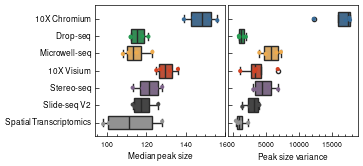

No such comm: 80b4e76ccf0d41399bd151798a8f5168


In [ ]:
# plt.close()
# fig, (ax1, ax2) = plt.subplots(
#     1, 2, figsize=(95*mm,45*mm)
# )


# # 绘制peak_value_mean条形图
# sns.boxplot(
#     data=raw_data_feature_df,
#     y="protocol",
#     x="peak_size_median",
#     hue="protocol",
#     hue_order=order,
#     ax=ax1,
#     palette=palette,
# )
# # 添加散点图
# sns.stripplot(
#     data=raw_data_feature_df,
#     y="protocol",
#     x="peak_size_median",
#     hue="protocol",
#     hue_order=order,
#     dodge=False,
#     size=3,
#     ax=ax1,
#     palette=palette,
# )

# ax1.set_xlabel("Median peak size")
# ax1.yaxis.set_tick_params(labelsize=6)

# sns.boxplot(
#     data=raw_data_feature_df,
#     y="protocol",
#     x="peak_size_var",
#     hue="protocol",
#     hue_order=order,
#     ax=ax2,
#     palette=palette
# )
# # 添加散点图
# sns.stripplot(
#     data=raw_data_feature_df,
#     y="protocol",
#     x="peak_size_var",
#     hue="protocol",
#     hue_order=order,
#     dodge=False,
#     size=3,
#     ax=ax2,
#     palette=palette
# )
# ax2.set_yticklabels([])

# ax2.set_xlabel("Peak size variance")
# for ax in [ax1, ax2]:
#     ax.set_ylabel("")
#     ax.tick_params(which="minor", left=False)
#     ax.margins(y=0.06,x=0.07)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.02)
# plt.savefig("../../figures/fig2/peak_size_median_peak_size_var.pdf", bbox_inches='tight')
# plt.show()

In [ ]:
# plt.close()
# fig, (ax1, ax2) = plt.subplots(
#     1, 2, figsize=(95*mm,45*mm)
# )


# # 绘制peak_value_mean条形图
# sns.boxplot(
#     data=raw_data_feature_df,
#     y="protocol",
#     x="apex_position_median",
#     hue="protocol",
#     hue_order=order,
#     ax=ax1,
#     palette=palette,
# )
# # 添加散点图
# sns.stripplot(
#     data=raw_data_feature_df,
#     y="protocol",
#     x="apex_position_median",
#     hue="protocol",
#     hue_order=order,
#     dodge=False,
#     size=3,
#     ax=ax1,
#     palette=palette,
# )

# ax1.set_xlabel("Median apex distance to PAS")
# ax1.yaxis.set_tick_params(labelsize=6)

# sns.boxplot(
#     data=raw_data_feature_df,
#     y="protocol",
#     x="kurtosis_median",
#     hue="protocol",
#     hue_order=order,
#     ax=ax2,
#     palette=palette
# )
# # 添加散点图
# sns.stripplot(
#     data=raw_data_feature_df,
#     y="protocol",
#     x="kurtosis_median",
#     hue="protocol",
#     hue_order=order,
#     dodge=False,
#     size=3,
#     ax=ax2,
#     palette=palette
# )
# ax2.set_yticklabels([])

# ax2.set_xlabel("Median peak kurtosis")
# for ax in [ax1, ax2]:
#     ax.set_ylabel("")
#     ax.tick_params(which="minor", left=False)
#     ax.margins(y=0.06,x=0.07)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.02)
# plt.savefig("../../figures/fig2/apex_position_median_kurtosis_median.pdf", bbox_inches='tight')
# plt.show()

/tmp/ipykernel_2938/2275090784.py:13: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_2938/2275090784.py:40: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_2938/2275090784.py:66: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_2938/2275090784.py:100: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
/tmp/ipykernel_2938/2275090784.py:116: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.boxplot(
/tmp/ipykernel_2938/2275090784.py:143: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripp

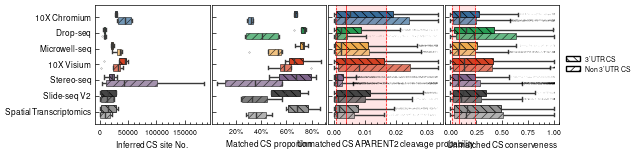

In [40]:
# from matplotlib.ticker import PercentFormatter
# hatch_styles = ["\\\\\\\\", "////"]

# plt.close()
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(
#     1, 4, figsize=(165*mm,42*mm),constrained_layout=True
# )
# colors = palette
# alpha_values = [1, 0.7]
# hue_order = ["onsite_unmatch", "offsite_unmatch"]


# sns.boxplot(
#     data=raw_data_feature_df[["protocol", "onsite_site_count", "offsite_site_count"]].melt(id_vars="protocol", value_name="site_count", var_name="type"),
#     x="site_count",
#     y="protocol",
#     hue="type",
#     # hue_order=order,
#     ax=ax1,
#     legend=False,
#     palette=palette,
#     flierprops={"markersize":0.2},
#     width=0.8,
# )

# for j, bar in enumerate(ax1.patches):
#     hatch_index = j // (len(ax1.patches) // len(hatch_styles))
#     bar.set_hatch(hatch_styles[hatch_index])
#     bar.set_alpha(alpha_values[hatch_index])
#     bar.set_facecolor(colors[j % (len(ax1.patches) // len(hatch_styles))])
#     bar.set_edgecolor('black')  # 设置描边颜色为黑色
#     bar.set_linewidth(0.5)  # 设置描边线宽为1
# ax1.spines['top'].set_visible(True)
# ax1.spines['right'].set_visible(True)
# ax1.set_xlabel("Inferred CS site No.")
# ax1.set_ylabel("")
# ax1.yaxis.set_tick_params(labelsize=6)
# ax1.tick_params(which="minor", left=False)

# sns.boxplot(
#     data=raw_data_feature_df[["protocol", "onsite_match_proportion", "offsite_match_proportion"]].melt(id_vars="protocol", value_name="match_proportion", var_name="type"),
#     x="match_proportion",
#     y="protocol",
#     hue="type",
#     # hue_order=order,
#     ax=ax2,
#     legend=False,
#     palette=palette,
#     flierprops={"markersize":0.2},
#     order=order,
#     width=0.8,
# )

# for j, bar in enumerate(ax2.patches):
#     hatch_index = j // (len(ax2.patches) // len(hatch_styles))
#     bar.set_hatch(hatch_styles[hatch_index])
#     bar.set_alpha(alpha_values[hatch_index])
#     bar.set_facecolor(colors[j % (len(ax2.patches) // len(hatch_styles))])
#     bar.set_edgecolor('black')  # 设置描边颜色为黑色
#     bar.set_linewidth(0.5)  # 设置描边线宽为1
# ax2.spines['top'].set_visible(True)
# ax2.spines['right'].set_visible(True)
# ax2.xaxis.set_major_formatter(PercentFormatter(xmax=1))
# ax2.set_xlabel("Matched CS proportion")

# sns.boxplot(
#     data=aparent_df[(aparent_df["protocol"] != "Annotated PAS") & (aparent_df["type"].isin(["onsite_unmatch","offsite_unmatch"]))],
#     x="prob",
#     y="protocol",
#     hue="type",
#     ax=ax3,
#     legend=False,
#     palette=palette,
#     showfliers=False,
#     order=order,
#     width=0.8,
# )

# for j, bar in enumerate(ax3.patches):
#     hatch_index = j // (len(ax3.patches) // len(hatch_styles))
#     bar.set_hatch(hatch_styles[hatch_index])
#     bar.set_alpha(alpha_values[hatch_index])
#     bar.set_facecolor(colors[j % (len(ax3.patches) // len(hatch_styles))])
#     bar.set_edgecolor('black')  # 设置描边颜色为黑色
#     bar.set_linewidth(0.5)  # 设置描边线宽为1
# ax3.spines['top'].set_visible(True)
# ax3.spines['right'].set_visible(True)
# ax3.set_xlabel("Unmatched CS APARENT2 cleavage probability")

# # 定义离群值和降采样比例
# def is_outlier(x):
#     Q1 = x.quantile(0.25)
#     Q3 = x.quantile(0.75)
#     IQR = Q3 - Q1
#     return (x < Q1 - 1.5 * IQR) | (x > Q3 + 1.5 * IQR)

# filtered_aparent_df = aparent_df[(aparent_df["protocol"] != "Annotated PAS") & (aparent_df["type"].isin(["onsite_unmatch","offsite_unmatch"]))]
# aparent_outliers = filtered_aparent_df[filtered_aparent_df.groupby(["protocol","type"])["prob"].transform(is_outlier)].groupby(["protocol","type"]).sample(frac=0.05).sort_values(["protocol","type"], ascending=False)

# sns.stripplot(
#     data=aparent_outliers,
#     x="prob",
#     y="protocol",
#     hue="type",
#     dodge=True,
#     size=0.3,
#     ax=ax3,
#     color="black",
#     alpha=0.5,
#     legend=False,
#     order=order,
    
# )

# # ax4
# sns.boxplot(
#     data=phastcons_df[(phastcons_df["protocol"] != "Annotated PAS") & (phastcons_df["type"].isin(["onsite_unmatch","offsite_unmatch"]))][["protocol", "cons", "type"]],
#     x="cons",
#     y="protocol",
#     hue="type",
#     ax=ax4,
#     legend=False,
#     palette=palette,
#     showfliers=False,
#     order=order,
#     width=0.8,
# )

# for j, bar in enumerate(ax4.patches):
#     hatch_index = j // (len(ax4.patches) // len(hatch_styles))
#     bar.set_hatch(hatch_styles[hatch_index])
#     bar.set_alpha(alpha_values[hatch_index])
#     bar.set_facecolor(colors[j % (len(ax4.patches) // len(hatch_styles))])
#     bar.set_edgecolor('black')  # 设置描边颜色为黑色
#     bar.set_linewidth(0.5)  # 设置描边线宽为1
# ax4.spines['top'].set_visible(True)
# ax4.spines['right'].set_visible(True)
# ax4.set_xlabel("Unmatched CS conserveness")

# filtered_phastcons_df = phastcons_df[(phastcons_df["protocol"] != "Annotated PAS") & (phastcons_df["type"].isin(["onsite_unmatch","offsite_unmatch"]))]
# phastcons_outliers = filtered_phastcons_df[filtered_phastcons_df.groupby(["protocol","type"])["cons"].transform(is_outlier)].groupby(["protocol","type"]).sample(frac=0.05).sort_values(["protocol","type"], ascending=False)

# sns.stripplot(
#     data=phastcons_outliers[["protocol", "cons", "type"]],
#     x="cons",
#     y="protocol",
#     hue="type",
#     dodge=True,
#     size=0.3,
#     ax=ax4,
#     color="black",
#     alpha=0.5,
#     legend=False,
#     order=order,
# )


# for ax in (ax2, ax3, ax4):
#     ax.set_ylabel("")
#     ax.set_yticklabels([])
#     ax.tick_params(which="minor", left=False)
#     # ax2.set_ylabel("")
# # ax2.set_yticklabels([])
# # ax2.tick_params(which="minor", left=False)
# ax1.margins(y=0.06)
# ymin, ymax = ax1.get_ylim()
# for ax in (ax1, ax2, ax3, ax4):
#     ax.set_ylim([ymin, ymax])
# # for ax in (ax1, ax2):
# #     ax.margins(x=0.07,y=0.06)
# handles = [plt.Rectangle((0, 0), 1, 1, facecolor='w', edgecolor='k', hatch=hatch_style) for i, hatch_style in enumerate(hatch_styles)]
# labels = ["3'UTR CS", "Non 3'UTR CS"]
# plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))


# ax3.axvline(x=aparent_annotation_median, color='red', linestyle='-', linewidth=0.5)
# ax3.axvline(x=aparent_annotation_upper, color='red', linestyle='--', linewidth=0.5)
# ax3.axvline(x=aparent_annotation_lower, color='red', linestyle='--', linewidth=0.5)
# ax3.fill_betweenx(ax3.get_ylim(), aparent_annotation_lower, aparent_annotation_upper, color='red', alpha=0.1)

# ax4.axvline(x=phastcons_annotation_median, color='red', linestyle='-', linewidth=0.5)
# ax4.axvline(x=phastcons_annotation_upper, color='red', linestyle='--', linewidth=0.5)
# ax4.axvline(x=phastcons_annotation_lower, color='red', linestyle='--', linewidth=0.5)
# ax4.fill_betweenx(ax4.get_ylim(), phastcons_annotation_lower, phastcons_annotation_upper, color='red', alpha=0.1)

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.02)
# plt.show()
# plt.savefig("../../figures/cs.pdf", bbox_inches='tight',pad_inches=0)


In [81]:
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return [tuple(color) for color in np.array(palette).take(indices, axis=0)]

colors_from_values(raw_data_feature_df.groupby("protocol")["read_length"].mean().reindex(order), "Greens_d")

[(0.370806100217865, 0.7098039215686275, 0.440958605664488),
 (0.370806100217865, 0.7098039215686275, 0.440958605664488),
 (0.20344482891195695, 0.294158656926823, 0.229281045751634),
 (0.21390234525182622, 0.57999743688325, 0.31816993464052284),
 (0.5788491605792644, 0.8185005767012687, 0.5853030885556837),
 (0.21390234525182622, 0.57999743688325, 0.31816993464052284),
 (0.2686095091631424, 0.6564090734332949, 0.37005254389337433),
 (0.2686095091631424, 0.6564090734332949, 0.37005254389337433)]

/tmp/ipykernel_12673/2272824541.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


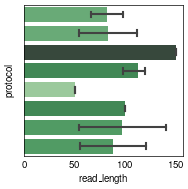

In [82]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.barplot(
    raw_data_feature_df,
    x="read_length",
    y="protocol",
    order=order,
    capsize=.3,
    palette=colors_from_values(
        raw_data_feature_df.groupby("protocol")["read_length"].mean().reindex(order),
        "Greens_d",
    ),
    ax=ax,
)
ax.set_yticklabels([])
ax.set_yticklabels([])
ax.tick_params(which="both", top=False, right=False, bottom=False, left=False)
ax.tick_params(which="minor", top=False, right=False, bottom=False, left=False)
plt.tight_layout()
plt.savefig("../plot/raw_bam_read_length_barplot.svg", bbox_inches='tight',dpi=300)

/tmp/ipykernel_12673/1208340976.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


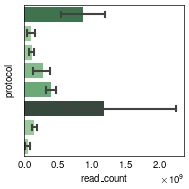

In [84]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.barplot(
    raw_data_feature_df,
    x="read_count",
    y="protocol",
    order=order,
    capsize=.3,
    palette=colors_from_values(
        raw_data_feature_df.groupby("protocol")["read_count"].mean().reindex(order),
        "Greens_d",
    ),
    ax=ax,
)
ax.set_yticklabels([])
ax.set_yticklabels([])
ax.tick_params(which="both", top=False, right=False, bottom=False, left=False)
ax.tick_params(which="minor", top=False, right=False, bottom=False, left=False)
plt.tight_layout()
plt.savefig("../plot/raw_bam_read_num_barplot.svg", bbox_inches='tight',dpi=300)

/tmp/ipykernel_12673/3284617176.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  params_df.groupby(["sample", "protocol"]).count()["Variable"].reset_index(),
/tmp/ipykernel_12673/3284617176.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  params_df.groupby(["sample", "protocol"]).count()["Variable"].reset_index().groupby("protocol")["Variable"].mean().reindex(order),
/tmp/ipykernel_12673/3284617176.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future 

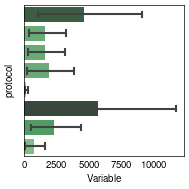

In [86]:
fig, ax = plt.subplots(figsize=(2, 2))
sns.barplot(
    params_df.groupby(["sample", "protocol"]).count()["Variable"].reset_index(),
    x="Variable",
    y="protocol",
    order=order,
    capsize=.3,
    palette=colors_from_values(
        params_df.groupby(["sample", "protocol"]).count()["Variable"].reset_index().groupby("protocol")["Variable"].mean().reindex(order),
        "Greens_d",
    ),
    ax=ax,
)
ax.set_yticklabels([])
ax.set_yticklabels([])
ax.tick_params(which="both", top=False, right=False, bottom=False, left=False)
ax.tick_params(which="minor", top=False, right=False, bottom=False, left=False)
plt.tight_layout()
plt.savefig("../plot/raw_bam_peak_num_barplot.svg", bbox_inches='tight',dpi=300)